In [80]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= '2.0'
from tensorflow import keras

import numpy as np
import pandas as pd
import scipy
import os
import time

from constants import *
from data import CSVDataHandler

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [81]:
def plot_property(data_:pdSeries):
    fig = plt.figure(figsize = FIGURE_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    ax.grid()
    plt.plot(data_)

In [82]:
def plot_ticker(data_:pdFrame, oc_width:int=5, hl_width:int=1):
    fig = plt.figure(figsize = FIGURE_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    ax.grid()        
    plt.plot(data_.index, data_.open, 'g--')
    palette = ['r' if o > c else 'g' for (o,c) in data_[['open','close']].values]
    plt.vlines(data_.index, data_.open, data_.close, colors=palette, linestyles='solid', linewidth=oc_width)
    plt.vlines(data_.index, data_.low, data_.high, colors=palette, linestyles='solid', linewidth=hl_width)
    plt.show()

In [83]:
def plot_max_min(data_: pdFrame, grid:bool = True):
    fig = plt.figure(figsize = FIGURE_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    if grid:
        minor_ticks = np.array(data_.index)
        ax.set_xticks(minor_ticks, minor=True)
        ax.grid(which='minor', alpha=0.5)
        ax.grid('both')

    plt.plot(data_.close, 'g--')
    plt.plot(data_.butter, 'r-')
    plt.plot(data_.butter_min, 'b.')
    plt.plot(data_.butter_max, 'k.')
    plt.plot(data_.close_min, 'g^')
    plt.plot(data_.close_max, 'rv')
    plt.show()

---
## Data loading

In [84]:
%%time
bars = CSVDataHandler('data', TIMEFRAME_MIN15,
           {'UVXY': {'src': 'av', 'tz': 'US/Eastern', 'exn':True, 'file':'UVXY_daily.csv'}, 
            'IMOEX': {'src': 'finam', 'tz': 'Europe/Moscow'},
            'SPFB': {'src': 'finam', 'tz': 'Europe/Moscow', 'exn': False},
            'SI': {'src': 'finam', 'tz': 'Europe/Moscow', 'exn': False}
           })

Wall time: 8.39 s


In [85]:
df = bars.all_bars('SPFB')
df.head()

,open,high,low,close,volume
datetime,,,,,
2009-07-16 18:15:00+04:00,63.73,63.73,63.73,63.73,100.0
2009-07-16 18:45:00+04:00,64.09,64.14,64.09,64.14,4.0
2009-07-16 19:00:00+04:00,64.07,64.25,64.07,64.25,6.0
2009-07-16 19:30:00+04:00,64.10,64.10,63.96,63.96,304.0
2009-07-16 20:00:00+04:00,64.03,64.03,64.03,64.03,300.0


In [86]:
df.describe()

,open,high,low,close,volume
count,137073.000000,137073.000000,137073.000000,137073.000000,137073.000000
mean,80.022741,80.127799,79.915604,80.022188,12372.605342
std,25.338745,25.343586,25.330392,25.338754,23680.779554
min,27.130000,27.280000,27.080000,27.140000,1.000000
25%,57.500000,57.610000,57.380000,57.500000,300.000000
50%,75.980000,76.080000,75.870000,75.970000,1551.000000
75%,107.530000,107.620000,107.440000,107.540000,15774.000000
max,126.760000,127.020000,126.150000,126.910000,750430.000000


In [87]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137073 entries, 2009-07-16 18:15:00+04:00 to 2019-08-31 00:00:00+03:00
Data columns (total 5 columns):
open      137073 non-null float64
high      137073 non-null float64
low       137073 non-null float64
close     137073 non-null float64
volume    137073 non-null float64
dtypes: float64(5)
memory usage: 6.3 MB


In [88]:
m = 1*10**5
train_data = df.iloc[:m, :]
test_data = df.iloc[m:, :]
print(train_data.shape[0])
print(test_data.shape[0])

100000
37073


----
## Data exloration

In [109]:
df = train_data.reset_index()
df.head()

,datetime,open,high,low,close,volume
0,2009-07-16 18:15:00+04:00,63.73,63.73,63.73,63.73,100.0
1,2009-07-16 18:45:00+04:00,64.09,64.14,64.09,64.14,4.0
2,2009-07-16 19:00:00+04:00,64.07,64.25,64.07,64.25,6.0
3,2009-07-16 19:30:00+04:00,64.10,64.10,63.96,63.96,304.0
4,2009-07-16 20:00:00+04:00,64.03,64.03,64.03,64.03,300.0


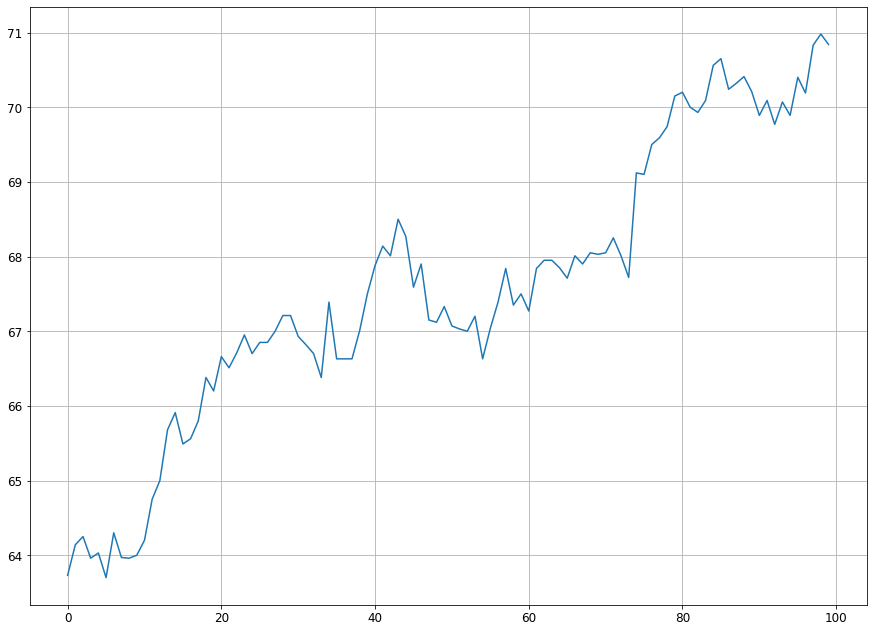

In [47]:
plot_property(df.close[:100])

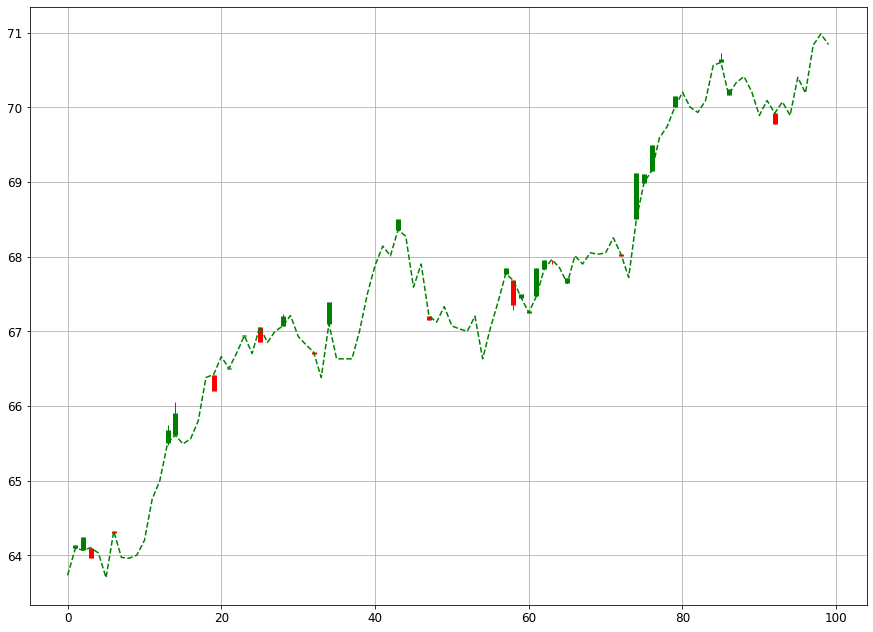

In [32]:
plot_ticker(df[['open','high','low','close']][:100])

### Forming target

In [33]:
from scipy import signal

def apply_butter_filter(data_:pdFrame, n, hc, skip) -> pdFrame:
    filter_ = signal.butter(n, 1/hc, output='sos')
    data_['butter'] = scipy.signal.sosfilt(filter_, data_.close)
    return data_[skip:]

In [34]:
import operator

def find_extrem(data_:pdSeries, is_max:bool, strict:bool=True) -> pdSeries:
    op_extr = operator.lt if is_max else operator.gt 
    op_not_strict = operator.le if is_max else operator.ge
    if strict:
        return op_extr(data_.shift(1), data_) & op_extr(data_.shift(-1), data_)
    else:
        return op_not_strict(data_.shift(1), data_) & op_extr(data_.shift(-1), data_)

In [48]:
df = apply_butter_filter(df, 2, 8, 3*8)
df.head()

,datetime,open,high,low,close,volume,butter
24,2009-07-20 12:00:00+04:00,66.70,66.70,66.70,66.70,1.0,66.430257
25,2009-07-20 13:15:00+04:00,67.06,67.06,66.85,66.85,5.0,66.569324
26,2009-07-20 14:00:00+04:00,66.85,66.85,66.85,66.85,3.0,66.678294
27,2009-07-20 14:15:00+04:00,67.00,67.00,67.00,67.00,7.0,66.765916
28,2009-07-20 14:30:00+04:00,67.07,67.23,67.07,67.21,7.0,66.846062


In [49]:
df.loc[find_extrem(df.butter, False, True), 'butter_min'] = df.butter
df.loc[find_extrem(df.butter, True, True), 'butter_max'] = df.butter
df.loc[find_extrem(df.close, False, False), 'close_min'] = df.close
df.loc[find_extrem(df.close, True, False), 'close_max'] = df.close

In [50]:
df.head(15)

,datetime,open,high,low,close,volume,butter,butter_min,butter_max,close_min,close_max
24,2009-07-20 12:00:00+04:00,66.70,66.70,66.70,66.70,1.0,66.430257,NaN,NaN,NaN,NaN
25,2009-07-20 13:15:00+04:00,67.06,67.06,66.85,66.85,5.0,66.569324,NaN,NaN,NaN,NaN
26,2009-07-20 14:00:00+04:00,66.85,66.85,66.85,66.85,3.0,66.678294,NaN,NaN,66.85,NaN
27,2009-07-20 14:15:00+04:00,67.00,67.00,67.00,67.00,7.0,66.765916,NaN,NaN,NaN,NaN
28,2009-07-20 14:30:00+04:00,67.07,67.23,67.07,67.21,7.0,66.846062,NaN,NaN,NaN,NaN
29,2009-07-20 15:15:00+04:00,67.21,67.21,67.21,67.21,3.0,66.929386,NaN,NaN,NaN,67.21
30,2009-07-20 16:15:00+04:00,66.93,66.93,66.93,66.93,1.0,67.002455,NaN,NaN,NaN,NaN
31,2009-07-20 16:30:00+04:00,66.82,66.82,66.82,66.82,3.0,67.040812,NaN,67.040812,NaN,NaN
32,2009-07-20 17:00:00+04:00,66.72,66.72,66.70,66.70,5.0,67.036074,NaN,NaN,NaN,NaN
33,2009-07-20 19:00:00+04:00,66.38,66.38,66.38,66.38,1.0,66.987096,NaN,NaN,66.38,NaN


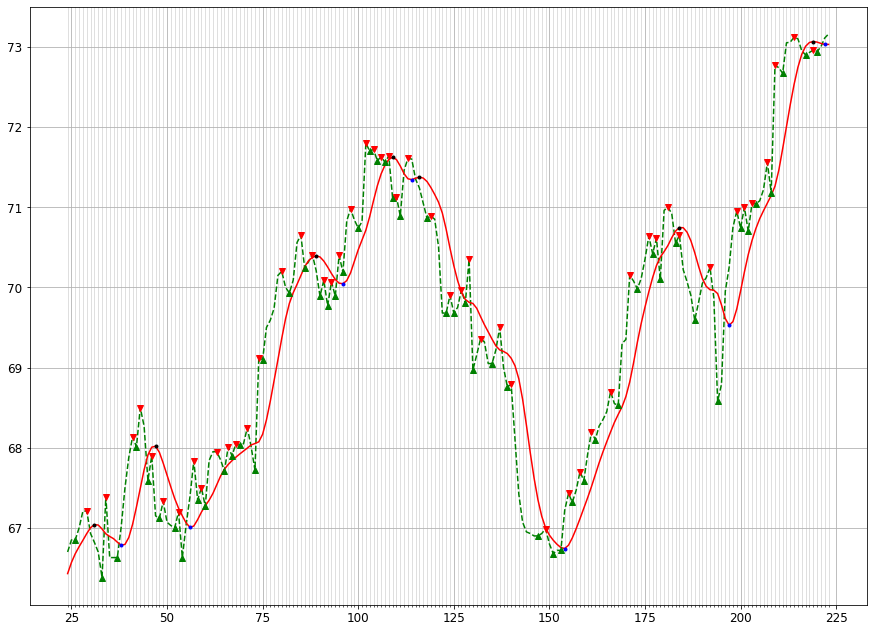

In [51]:
df_copy = df.copy()
plot_max_min(df_copy[:200])

In [41]:
def find_min(fst, fst_idx, snd, snd_idx) -> (int, bool):
    if (fst_idx >= len(fst)) and (snd_idx >= len(snd)):
        return (-1, True)
    if fst_idx >= len(fst): 
        return (snd_idx, False) 
    if snd_idx >= len(snd): 
        return (fst_idx, True)
    if fst[fst_idx] > snd[snd_idx]:
        return (snd_idx, False) 
    else:
        return (fst_idx, True)
    
def select_indices(filter_max, data_max, filter_min, data_min, data_:pdSeries):
    fmax_idx = 0; fmin_idx = 0
    dmax_idx = 0; dmin_idx = 0
    result_max = []; result_min = []
    prev_vals = []
    fi, is_max = find_min(filter_max, fmax_idx, filter_min, fmin_idx)
    while fi >= 0:
        f = filter_max if is_max else filter_min
        d = data_max if is_max else data_min
        i = dmax_idx if is_max else dmin_idx
        min_max = max if is_max else min
        while (i < len(d)) and (d[i] <= f[fi]):
            prev_vals.append(data_[d[i]])
            i += 1
        if len(prev_vals) > 0:
            # returns index of the last min/max value
            idx = min_max(range(len(prev_vals)), key=lambda j: (prev_vals[j], -j))
            if is_max:
                result_max.append(d[i - len(prev_vals) + idx])
                dmax_idx = i
                while data_min[dmin_idx] < result_max[-1]:
                    dmin_idx += 1
            else:
                result_min.append(d[i - len(prev_vals) + idx])
                dmin_idx = i
                while data_max[dmax_idx] < result_min[-1]:
                    dmax_idx += 1
            prev_vals = []
        if is_max:
            fmax_idx += 1
        else:
            fmin_idx += 1
        fi, is_max = find_min(filter_max, fmax_idx, filter_min, fmin_idx)
    return result_max, result_min

In [52]:
max_idx, min_idx = select_indices(np.array(df[df.butter_max.notnull()].index), 
                                  np.array(df[df.close_max.notnull()].index),
                                  np.array(df[df.butter_min.notnull()].index),  
                                  np.array(df[df.close_min.notnull()].index), 
                                  df.close)
df.close_min = np.NaN
df.loc[df.index.isin(min_idx), 'close_min'] = df.close
df.close_max = np.NaN
df.loc[df.index.isin(max_idx), 'close_max'] = df.close

In [53]:
df[:50]

,datetime,open,high,low,close,volume,butter,butter_min,butter_max,close_min,close_max
24,2009-07-20 12:00:00+04:00,66.70,66.70,66.70,66.70,1.0,66.430257,NaN,NaN,NaN,NaN
25,2009-07-20 13:15:00+04:00,67.06,67.06,66.85,66.85,5.0,66.569324,NaN,NaN,NaN,NaN
26,2009-07-20 14:00:00+04:00,66.85,66.85,66.85,66.85,3.0,66.678294,NaN,NaN,NaN,NaN
27,2009-07-20 14:15:00+04:00,67.00,67.00,67.00,67.00,7.0,66.765916,NaN,NaN,NaN,NaN
28,2009-07-20 14:30:00+04:00,67.07,67.23,67.07,67.21,7.0,66.846062,NaN,NaN,NaN,NaN
29,2009-07-20 15:15:00+04:00,67.21,67.21,67.21,67.21,3.0,66.929386,NaN,NaN,NaN,67.21
30,2009-07-20 16:15:00+04:00,66.93,66.93,66.93,66.93,1.0,67.002455,NaN,NaN,NaN,NaN
31,2009-07-20 16:30:00+04:00,66.82,66.82,66.82,66.82,3.0,67.040812,NaN,67.040812,NaN,NaN
32,2009-07-20 17:00:00+04:00,66.72,66.72,66.70,66.70,5.0,67.036074,NaN,NaN,NaN,NaN
33,2009-07-20 19:00:00+04:00,66.38,66.38,66.38,66.38,1.0,66.987096,NaN,NaN,66.38,NaN


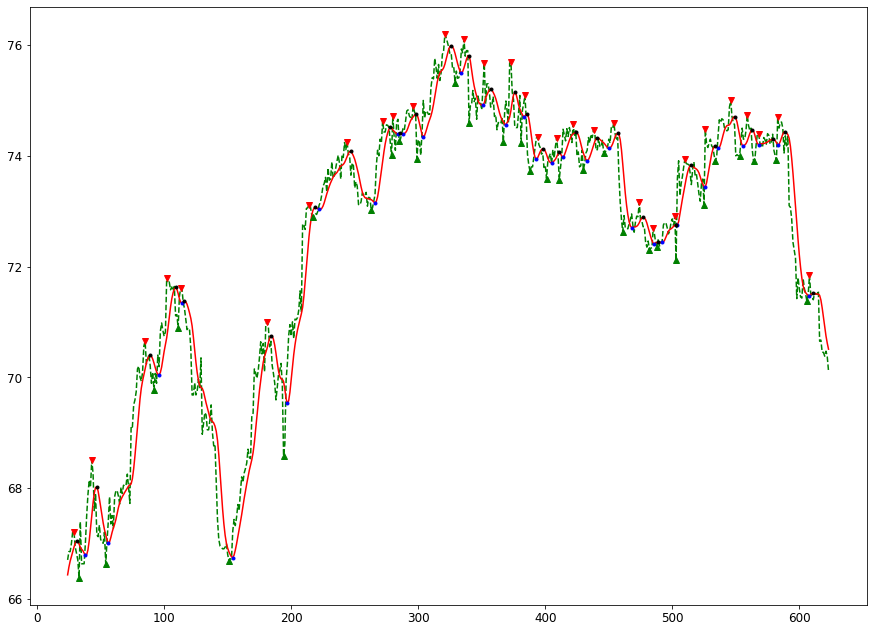

In [54]:
plot_max_min(df[:600], False)

In [55]:
def calc_trades(data_max, data_min):
    i = j = 0
    num_ = sum_ = 0
    prev_val = 0.0
    prev_max = data_min[0] < data_max[0]
    
    while i < len(data_min) and j < len(data_max): 
        if data_min[i] < data_max[j]: 
            if prev_max:
                sum_ += (data_min[i] - prev_val)
                num_ += 2
                prev_val = data_min[i]
            i+=1
        else: # data_min[i] > data_max[j]: 
            if not prev_max:
                sum_ += (data_max[j] - prev_val)
                num_ += 2
                prev_val = data_max[j]
            j+=1
    return num_, sum_/num_

In [56]:
calc_trades(np.array(df[df.close_max.notnull()].index), 
            np.array(df[df.close_min.notnull()].index))

(10508, 9.513799010277884)

-----
## All together

In [57]:
import operator

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import signal

In [119]:
class TargetAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, filter_cycle:int, skip:bool=True, shift:bool=False):
        self.hc = filter_cycle
        self.skip = skip
        self.shift = shift
        
    def fit(self, x, y=None):
        return self
    
    def _apply_butter_filter(self, X: pdFrame, n:int, hc:int, skip:int) -> pdFrame:
        f = signal.butter(n, 1/hc, output='sos')
        X.loc[:, 'butter'] = scipy.signal.sosfilt(f, X.close)
        return X[skip:]
    
    def _find_extrem(self, x:pdSeries, is_max:bool, strict:bool) -> pdSeries:
        op_extr = operator.lt if is_max else operator.gt 
        op_not_strict = operator.le if is_max else operator.ge
        if strict:
            return op_extr(x.shift(1), x) & op_extr(x.shift(-1), x)
        else:
            return op_not_strict(x.shift(1), x) & op_extr(x.shift(-1), x)
    
    def _find_min(self, fst, fst_idx, snd, snd_idx) -> (int, bool):
        if (fst_idx >= len(fst)) and (snd_idx >= len(snd)):
            return (-1, True)
        if fst_idx >= len(fst): 
            return (snd_idx, False) 
        if snd_idx >= len(snd): 
            return (fst_idx, True)
        if fst[fst_idx] > snd[snd_idx]:
            return (snd_idx, False) 
        else:
            return (fst_idx, True)

    def _select_indices(self, filter_max, data_max, filter_min, data_min, x:pdSeries):
        fmax_idx = fmin_idx = 0
        dmax_idx = dmin_idx = 0
        result_max = []
        result_min = []
        prev_vals = []
        fi, is_max = self._find_min(filter_max, fmax_idx, filter_min, fmin_idx)
        while fi >= 0:
            f = filter_max if is_max else filter_min
            d = data_max if is_max else data_min
            i = dmax_idx if is_max else dmin_idx
            min_max = max if is_max else min
            while (i < len(d)) and (d[i] <= f[fi]):
                prev_vals.append(x[d[i]])
                i += 1
            if len(prev_vals) > 0:
                # returns index of the last min[max] value
                idx = min_max(range(len(prev_vals)), key=lambda j: (prev_vals[j], -j))
                if is_max:
                    result_max.append(d[i - len(prev_vals) + idx])
                    dmax_idx = i
                    while data_min[dmin_idx] < result_max[-1]:
                        dmin_idx += 1
                else:
                    result_min.append(d[i - len(prev_vals) + idx])
                    dmin_idx = i
                    while data_max[dmax_idx] < result_min[-1]:
                        dmax_idx += 1
                prev_vals = []
            if is_max:
                fmax_idx += 1
            else:
                fmin_idx += 1
            fi, is_max = self._find_min(filter_max, fmax_idx, filter_min, fmin_idx)
        return result_max, result_min
    
    def transform(self, X):
        skip_no = 3*self.hc if self.skip else 0
        X = self._apply_butter_filter(X.copy(), 2, self.hc, skip_no)
        
        X.loc[self._find_extrem(X.butter, False, True), 'butter_min'] = X.butter
        X.loc[self._find_extrem(X.butter, True, True), 'butter_max'] = X.butter
        X.loc[self._find_extrem(X.close, False, False), 'close_min'] = X.close
        X.loc[self._find_extrem(X.close, True, False), 'close_max'] = X.close

        max_idx, min_idx = self._select_indices(
                                    np.array(X[X.butter_max.notnull()].index), 
                                    np.array(X[X.close_max.notnull()].index),
                                    np.array(X[X.butter_min.notnull()].index),  
                                    np.array(X[X.close_min.notnull()].index), 
                                    X.close)
        X.drop(columns=['close_min', 'close_max'], inplace=True)
        X.loc[X.index.isin(max_idx), 'close_max'] = X.close
        X.loc[X.index.isin(min_idx), 'close_min'] = X.close        
        
        return X

In [122]:
df.head()

,datetime,open,high,low,close,volume
0,2009-07-16 18:15:00+04:00,63.73,63.73,63.73,63.73,100.0
1,2009-07-16 18:45:00+04:00,64.09,64.14,64.09,64.14,4.0
2,2009-07-16 19:00:00+04:00,64.07,64.25,64.07,64.25,6.0
3,2009-07-16 19:30:00+04:00,64.10,64.10,63.96,63.96,304.0
4,2009-07-16 20:00:00+04:00,64.03,64.03,64.03,64.03,300.0


In [127]:
target_pipeline = Pipeline([
        ('target_adder', TargetAttributesAdder(45))
    ])
df_target = target_pipeline.fit_transform(df)
df_target.head()

,datetime,open,high,low,close,volume,butter,butter_min,butter_max,close_max,close_min
135,2009-07-29 14:00:00+04:00,69.05,69.05,69.05,69.05,10.0,70.691264,NaN,NaN,NaN,NaN
136,2009-07-29 14:30:00+04:00,69.22,69.22,69.22,69.22,15.0,70.650656,NaN,NaN,NaN,NaN
137,2009-07-29 16:30:00+04:00,69.50,69.50,69.50,69.50,2.0,70.607352,NaN,NaN,NaN,NaN
138,2009-07-29 17:45:00+04:00,69.20,69.20,69.00,69.00,30.0,70.562072,NaN,NaN,NaN,NaN
139,2009-07-29 18:15:00+04:00,68.89,68.89,68.76,68.76,31.0,70.514098,NaN,NaN,NaN,NaN


In [61]:
def calc_trades(data_max, data_min):
    i = j = 0
    num_ = sum_ = 0
    prev_val = 0.0
    prev_max = data_min[0] < data_max[0]
    
    while i < len(data_min) and j < len(data_max): 
        if data_min[i] < data_max[j]: 
            if prev_max:
                sum_ += (data_min[i] - prev_val)
                num_ += 2
                prev_val = data_min[i]
            i+=1
        else: # data_min[i] > data_max[j]: 
            if not prev_max:
                sum_ += (data_max[j] - prev_val)
                num_ += 2
                prev_val = data_max[j]
            j+=1
    return num_, sum_/num_

In [128]:
calc_trades(np.array(df_target[df_target.close_max.notnull()].index), 
            np.array(df_target[df_target.close_min.notnull()].index))

(2072, 48.14623552123552)

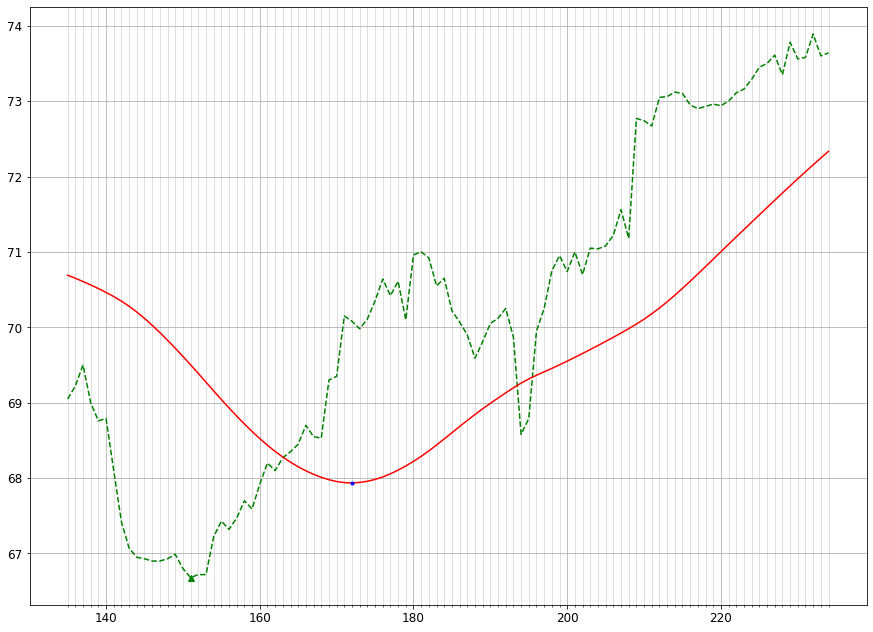

In [131]:
plot_max_min(df_target[:100], True)

----
## Debug notes

In [55]:
def select_indices(op, filter_idx, data_idx, data_:pdSeries):
    result = []
    prev_vals = []
    i = 0
    for fi in filter_idx:
        while (i < len(data_idx)) and (data_idx[i] <= fi):
            prev_vals.append(data_[data_idx[i]])
            i += 1
        if (i > 0) and (len(prev_vals) > 0):
            mi = 1
            if (len(prev_vals) > 1) and op(prev_vals[-2], prev_vals[-1]):
                mi = 2
            result.append(data_idx[i - mi])
            prev_vals = []
    return result

In [155]:
def select_indices(filter_idx, data_idx, func_, data_:pdSeries):
    result = []
    prev_vals = []
    i = 0
    for fi in filter_idx:
        while (i < len(data_idx)) and (data_idx[i] <= fi):
            prev_vals.append(data_[data_idx[i]])
            i += 1
        if (i > 0) and (len(prev_vals) > 0):
            # consider no more than 3 last max/mins
            prev_vals = prev_vals[-3:]
            # returns index of the last min/max value
            idx = func_(range(len(prev_vals)), key=lambda j: (prev_vals[j], -j))
            result.append(data_idx[i - len(prev_vals) + idx])
            prev_vals = []
    return result